In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(
    root ='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root ='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 338kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.86MB/s]


In [3]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x): # x : 入力
        z1 = F.relu(self.fc1(x))
        z2 = F.relu(self.fc2(z1))
        y = self.fc3(z2)
        return y

In [6]:
input_size = 28*28
hidden1_size = 1024
hidden2_size = 512
output_size = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net(input_size, hidden1_size, hidden2_size, output_size).to(device)
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
# 損失関数　criterion：基準
# CrossEntropyLoss：交差エントロピー誤差関数
criterion = nn.CrossEntropyLoss()

# 最適化法の指定　optimizer：最適化
# SGD：確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
def train_model(model, train_loader, criterion, optimizer, device='cpu'):

    train_loss = 0.0
    num_train = 0

    # 学習モデルに変換
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        # batch数をカウント
        num_train += len(labels)

        images, labels = images.view(-1, 28*28).to(device), labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 推論(順伝播)
        outputs = model(images)

        # 損失の算出
        loss = criterion(outputs, labels)

        # 誤差逆伝播
        loss.backward()

        # パラメータの更新
        optimizer.step()

        # lossを加算
        train_loss += loss.item()

    # lossの平均値を取る
    train_loss = train_loss / num_train

    return train_loss


In [9]:
def test_model(model, test_loader, criterion, optimizer, device='cpu'):

    test_loss = 0.0
    num_test = 0

    # modelを評価モードに変更
    model.eval()

    with torch.no_grad(): # 勾配計算の無効化
        for i, (images, labels) in enumerate(test_loader):
            num_test += len(labels)
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

        # lossの平均値を取る
        test_loss = test_loss / num_test
    return test_loss


In [10]:
def learning(model, train_loader, test_loader, criterion, opimizer, num_epochs, device='cpu'):

    train_loss_list = []
    test_loss_list = []

    # epoch数分繰り返す
    for epoch in range(1, num_epochs+1, 1):

        train_loss = train_model(model, train_loader, criterion, optimizer, device=device)
        test_loss = test_model(model, test_loader, criterion, optimizer, device=device)

        print("epoch : {}, train_loss : {:.5f}, test_loss : {:.5f}" .format(epoch, train_loss, test_loss))

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    return train_loss_list, test_loss_list


In [11]:
num_epochs = 10
train_loss_list, test_loss_list = learning(model, train_loader, test_loader, criterion, optimizer, num_epochs, device=device)


epoch : 1, train_loss : 0.00793, test_loss : 0.00646
epoch : 2, train_loss : 0.00494, test_loss : 0.00414
epoch : 3, train_loss : 0.00362, test_loss : 0.00345
epoch : 4, train_loss : 0.00312, test_loss : 0.00307
epoch : 5, train_loss : 0.00284, test_loss : 0.00292
epoch : 6, train_loss : 0.00265, test_loss : 0.00270
epoch : 7, train_loss : 0.00249, test_loss : 0.00258
epoch : 8, train_loss : 0.00237, test_loss : 0.00255
epoch : 9, train_loss : 0.00227, test_loss : 0.00241
epoch : 10, train_loss : 0.00219, test_loss : 0.00233


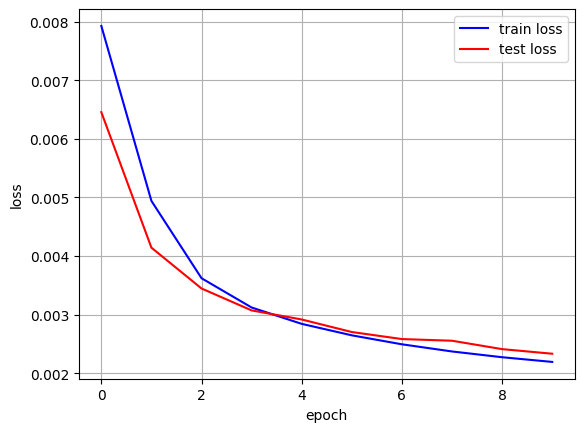

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_list)), train_loss_list, c='b', label='train loss')
plt.plot(range(len(test_loss_list)), test_loss_list, c='r', label='test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()


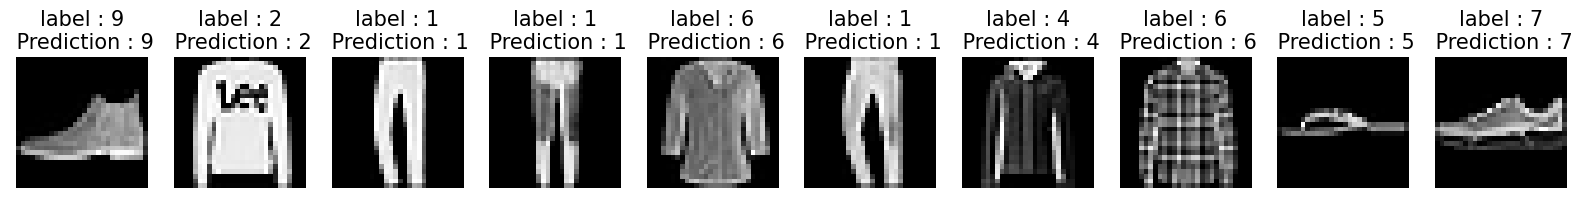

In [13]:
plt.figure(figsize=(20, 10))
for i in range(10):
    image, label = test_dataset[i]
    image = image.view(-1, 28*28).to(device)

    # 推論
    prediction_label = torch.argmax(model(image))

    ax = plt.subplot(1, 10, i+1)

    plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label), fontsize=15)
plt.show()


In [14]:
correct_estimate = 0
incorrect_index_list =[]
prediction_label_of_incorrect_index = []
for i in range(len(test_dataset)):
  image, label = test_dataset[i]
  image = image.view(-1, 28*28).to(device)
  prediction_label = torch.argmax(model(image))
  if prediction_label == label:
    correct_estimate += 1
  elif len(incorrect_index_list) < 10:
    incorrect_index_list.append(i)
    prediction_label_of_incorrect_index.append(prediction_label)
print(f'正解数:{correct_estimate}　テストデータ総数:{len(test_dataset)}　正解率:{correct_estimate/len(test_dataset)}')
#訓練しなおすとほんの少しだけ正解数が変動するはず


正解数:7998　テストデータ総数:10000　正解率:0.7998


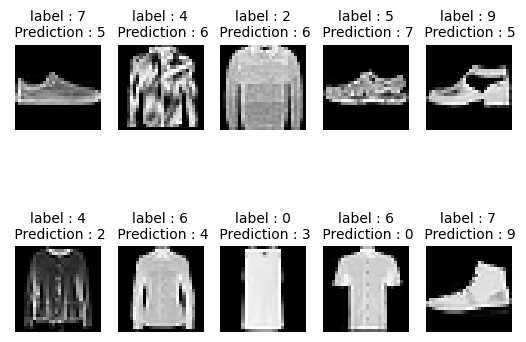

In [15]:
#誤った予測を立ててしまった画像のうちの10個に対し、予測と正解、画像を表示する。
for i in range(len(incorrect_index_list)):
  image, label = test_dataset[incorrect_index_list[i]]
  ax = plt.subplot(2, 5, i+1)
  plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
  ax.axis('off')
  ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label_of_incorrect_index[i]), fontsize=10)
plt.show()
